In [1]:
import MDAnalysis as mda
import numpy as np
from MDAnalysis.analysis.msd import EinsteinMSD

# dirs = [
#     "12-0_test-d-3_lim_in-lmp/",
#     "13-0_test-d-4_lim_in-lmp/",
#     "14-0_test-d-5_lim_in-lmp/",
#     "15-0_test-d-6_lim_in-lmp/",
#     "16-0_test-d-7_lim_in-lmp/",
# ]

path1 = '/raid/hwding/gpumd/gpumd_dynamic/test4/fix/fix-C/'

file1 = path1 + "properties_OH.xyz"


def write_msd_xyz(infile="properties.xyz", outfile="msd.xyz", encoding="utf-8"):
    """
    读取扩展XYZ(properties.xyz)：
      a) 按每帧: 第1行n_atoms, 第2行comment, 接着n_atoms行原子数据；先统计并输出总帧数
      b) 对每个原子行：保留第1列symbol + 第13-15列(unwrapped_position) 作为新的 x y z
      c) 每帧写入：原来的前两行 + 提取后的原子行 到 msd.xyz（与输入文件同目录）
    """
    import os

    # 让输出文件位于与输入文件相同的文件夹
    outfile = os.path.join(os.path.dirname(os.path.abspath(infile)), outfile)

    # pass 1: count frames
    nframes = 0
    with open(infile, "r", encoding=encoding) as f:
        while True:
            line = f.readline()
            if not line:
                break
            line = line.strip()
            if not line:
                continue
            try:
                n = int(line)
            except ValueError as e:
                raise ValueError(f"Frame header (n_atoms) parse failed at frame {nframes+1}: {line}") from e
            _comment = f.readline()
            if not _comment:
                raise EOFError(f"Unexpected EOF after n_atoms line in frame {nframes+1}")
            for _ in range(n):
                atom_line = f.readline()
                if not atom_line:
                    raise EOFError(f"Unexpected EOF in atom lines of frame {nframes+1}")
            nframes += 1

    print(nframes)

    # pass 2: write msd.xyz
    with open(infile, "r", encoding=encoding) as fin, open(outfile, "w", encoding=encoding) as fout:
        for _ in range(nframes):
            n_line = fin.readline()
            while n_line and not n_line.strip():
                n_line = fin.readline()
            if not n_line:
                break
            n = int(n_line.strip())
            comment = fin.readline()
            fout.write(f"{n}\n")
            fout.write(comment if comment.endswith("\n") else comment + "\n")

            for _ in range(n):
                parts = fin.readline().split()
                if len(parts) < 15:
                    raise ValueError(f"Atom line has <15 columns, cannot read unwrapped_position: {' '.join(parts)}")
                sym = parts[0]
                x, y, z = parts[12], parts[13], parts[14]  # 1-based 13-15
                fout.write(f"{sym} {x} {y} {z}\n")

    return outfile

if __name__ == "__main__":
    write_msd_xyz(infile=file1, outfile="msd_OH.xyz")


/raid/hwding/anaconda3/envs/gpumd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1000


In [3]:
file2 =  path1+ "msd_OH.xyz"
u = mda.Universe(file2)
ag = u.select_atoms("name O")
for ts in u.trajectory:
    z = ag.positions[0, 2]   # 每帧第一个O原子的z
    print(ts.frame, ts.time, z)

       

/tmp/ipykernel_1446919/3545884611.py:6: UserWarning: Reader has no dt information, set to 1.0 ps
  print(ts.frame, ts.time, z)


0 0.0 8.850626
1 1.0 5.300355
2 2.0 5.780383
3 3.0 8.139729
4 4.0 6.9820614
5 5.0 6.778811
6 6.0 4.646477
7 7.0 5.7828507
8 8.0 4.751467
9 9.0 2.5151734
10 10.0 4.5464478
11 11.0 4.620902
12 12.0 4.94495
13 13.0 4.426945
14 14.0 2.9394894
15 15.0 -0.8837467
16 16.0 -2.9451637
17 17.0 -2.6360295
18 18.0 -1.7624927
19 19.0 2.4739392
20 20.0 5.5829186
21 21.0 3.6667557
22 22.0 2.418118
23 23.0 1.134934
24 24.0 0.56417954
25 25.0 -1.5862806
26 26.0 -0.8151289
27 27.0 0.91642237
28 28.0 1.5716559
29 29.0 2.9508705
30 30.0 4.2442718
31 31.0 4.3857293
32 32.0 5.285856
33 33.0 4.928111
34 34.0 6.3242493
35 35.0 5.2688437
36 36.0 6.129922
37 37.0 9.120389
38 38.0 5.664053
39 39.0 -1.7639208
40 40.0 -3.8249924
41 41.0 -1.1262251
42 42.0 -1.266999
43 43.0 5.467595
44 44.0 5.007874
45 45.0 4.192081
46 46.0 5.8386517
47 47.0 9.761448
48 48.0 7.282674
49 49.0 7.5531054
50 50.0 8.758011
51 51.0 4.849181
52 52.0 8.467535
53 53.0 7.0149274
54 54.0 8.898972
55 55.0 8.248904
56 56.0 6.0113673
57 57.0 4.6

100%|██████████| 199/199 [00:00<00:00, 18593.60it/s]


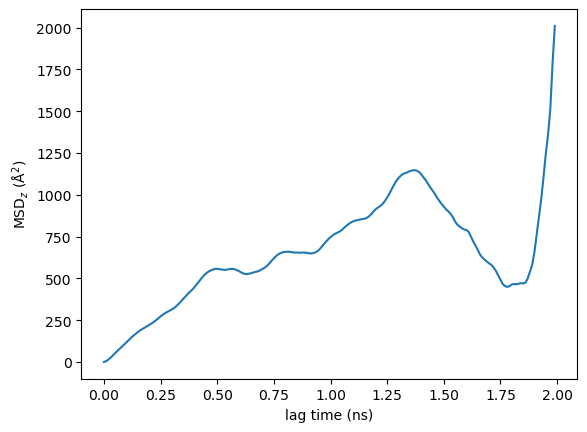

In [7]:
MSD_z = EinsteinMSD(ag, msd_type="z", fft=False)
MSD_z.run(start=800,stop=1000)   # 从第1500帧开始（0-based）
msd_z = MSD_z.results.timeseries   # 单位：Å^2
nframes = MSD_z.n_frames
import matplotlib.pyplot as plt
dt_fs = 10000
lag_ns = np.arange(nframes) * (dt_fs / 1000000.0)

plt.plot(lag_ns, msd_z)
plt.xlabel("lag time (ns)")
plt.ylabel("MSD$_z$ (Å$^2$)")
plt.show()

Dz = 3.46935e-05 cm^2/s
slope = 693.87 Å^2/ns
Dz = 346.935 Å^2/ns = 3.46935e-05 cm^2/s
r = 0.9786


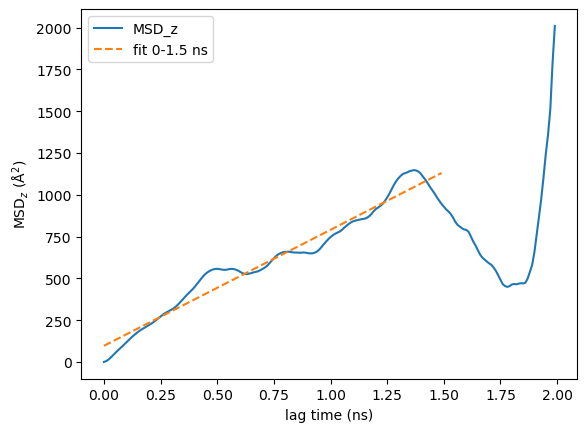

In [10]:
from scipy.stats import linregress

# --- 线性拟合区间（单位：ps），按你的曲线线性段自行改 ---
t1_ns = 0
t2_ns = 1.5

i1 = int(t1_ns / (dt_fs / 1000000.0))
i2 = int(t2_ns / (dt_fs / 1000000.0))

fit = linregress(lag_ns[i1:i2], msd_z[i1:i2])
slope = fit.slope              # Å^2/ps

# 1D z方向：D = slope / (2*1)
Dz_A2ps = slope / 2.0          # Å^2/ps
Dz_cm2s = Dz_A2ps * 1e-7  # cm^2/s（因为 1 Å^2/ns = 1e-7 cm^2/s）
print(f"Dz = {Dz_cm2s:.6g} cm^2/s")    # m^2/s（因为 1 Å^2/ps = 1e-8 m^2/s）

print(f"slope = {slope:.6g} Å^2/ns")
print(f"Dz = {Dz_A2ps:.6g} Å^2/ns = {Dz_cm2s:.6g} cm^2/s")
print(f"r = {fit.rvalue:.4f}")

# 可选：把拟合线画在图上
plt.figure()
plt.plot(lag_ns, msd_z, label="MSD_z")
plt.plot(lag_ns[i1:i2], fit.intercept + slope*lag_ns[i1:i2], "--", label=f"fit {t1_ns}-{t2_ns} ns")
plt.xlabel("lag time (ns)")
plt.ylabel("MSD$_z$ (Å$^2$)")
plt.legend()
plt.show()

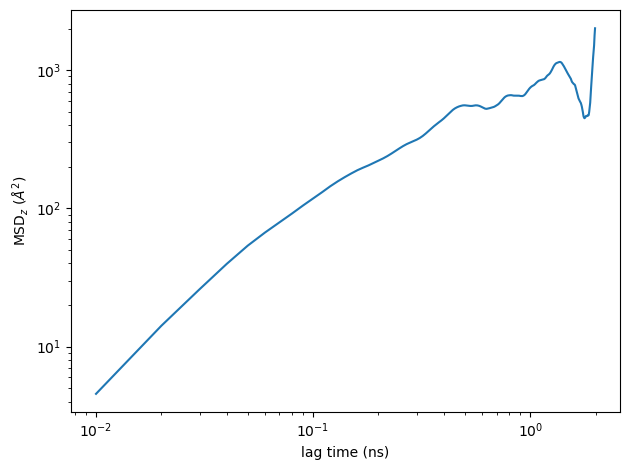

In [12]:
mask = (lag_ns > 0) & (msd_z > 0)

plt.figure()
plt.loglog(lag_ns[mask], msd_z[mask])
plt.xlabel("lag time (ns)")
plt.ylabel(r"MSD$_z$ ($\AA^2$)")
plt.tight_layout()
plt.show()

frames used: 1500 to 1999 (total: 500 )
Dz (z-方向, 1D): 0.0002753205600180554  (units: length^2/ns)


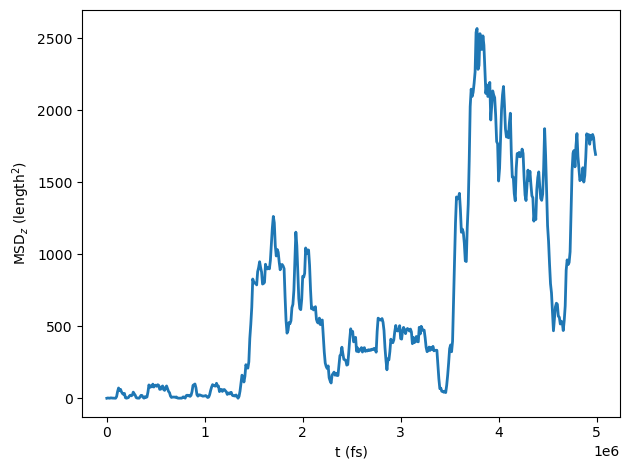

In [72]:
import numpy as np
import matplotlib.pyplot as plt

DT_FS = 10000.0  # 每帧间隔 10000 fs
START = 1500
STOP_INCLUSIVE = 2000  # 想包含第2000帧

def iter_xyz_z(path, element="O"):
    z_list = []
    sel_idx = None

    with open(path, "r", encoding="utf-8") as f:
        while True:
            line = f.readline()
            if not line:
                break
            line = line.strip()
            if not line:
                continue

            n = int(line)
            _comment = f.readline()  # 不用Time=，我们自己用DT_FS

            symbols = []
            z_all = np.empty(n, dtype=float)
            for i in range(n):
                parts = f.readline().split()
                symbols.append(parts[0])
                z_all[i] = float(parts[3])

            if sel_idx is None:
                sel_idx = np.array([i for i, s in enumerate(symbols) if s == element], dtype=int)
                if sel_idx.size == 0:
                    raise ValueError(f"第一帧未找到元素 {element}")

            z_list.append(z_all[sel_idx])

    z = np.vstack(z_list)  # (n_frames, n_O)
    return z

def msd_z_from_slice(z, start, stop_exclusive):
    zslice = z[start:stop_exclusive]
    dz = zslice - zslice[0:1, :]
    msd = np.mean(dz * dz, axis=1)
    return msd

def fit_Dz(times_fs, msd, fit_start_frac=0.6):
    # 1D: MSDz ≈ 2 Dz t
    n = len(times_fs)
    i0 = int(np.floor(n * fit_start_frac))
    tt = times_fs[i0:]
    yy = msd[i0:]
    A = np.vstack([tt, np.ones_like(tt)]).T
    slope, intercept = np.linalg.lstsq(A, yy, rcond=None)[0]
    Dz = slope / 2.0
    return Dz, slope, intercept, i0

import MDAnalysis as mda
import numpy as np
from MDAnalysis.analysis.msd import EinsteinMSD

# dirs = [
#     "12-0_test-d-3_lim_in-lmp/",
#     "13-0_test-d-4_lim_in-lmp/",
#     "14-0_test-d-5_lim_in-lmp/",
#     "15-0_test-d-6_lim_in-lmp/",
#     "16-0_test-d-7_lim_in-lmp/",
# ]

path1 = '/raid/hwding/gpumd/gpumd_dynamic/test4/temperature/200K/'

file2 = path1 + "msd.xyz"






if __name__ == "__main__":
    z = iter_xyz_z(file2, element="O")
    n_frames = z.shape[0]

    # 计算切片端点
    stop_excl = min(STOP_INCLUSIVE + 1, n_frames)  # 包含STOP_INCLUSIVE
    if START >= n_frames or START >= stop_excl:
        raise ValueError(f"帧范围无效：START={START}, stop_excl={stop_excl}, n_frames={n_frames}")

    msd = msd_z_from_slice(z, START, stop_excl)

    frames = np.arange(START, stop_excl)
    times_fs = (frames - frames[0]) * DT_FS  # 从0开始的时间

    Dz, slope, intercept, i0 = fit_Dz(times_fs, msd, fit_start_frac=0.6)
    print("frames used:", START, "to", stop_excl - 1, "(total:", len(frames), ")")
    print("Dz (z-方向, 1D):", Dz, " (units: length^2/ns)")

    plt.plot(times_fs, msd, lw=2)
    plt.xlabel("t (fs)")
    plt.ylabel(r"MSD$_z$ (length$^2$)")
    plt.tight_layout()
    plt.show()